<a href="https://colab.research.google.com/github/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/Chapter3_2_Going_Beyond_the_Basics_Detecting_Features_in_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3: Going Beyond the Basics: Detecting Features in Images
Hi, chào mọi người. Như trên tựa đề đã ghi, ở chương này, tụi mình sẽ đi xa hơn nữa, hơn cả mức cơ bản. Tìm hiểu sâu hơn với các khái niệm mới trong mạng thần kinh.

<img src="https://gregorygundersen.com/image/cnns/41847277995.png" alt="Description" style="width:30%;">

Chương này khá dài nên mình sẽ tổng quan trước những cái mới mà chúng mình sẽ học nha:

1. Cách sử dụng **phương pháp tích chập** để trích xuất các **đặc trưng** trong ảnh. Thông qua đó, ta hiểu được cách sử dụng các **lớp tích chập (Convolution layer)** để tăng hiệu quả học các bức ảnh. Thêm đó là phần **lớp gộp (Pooling layer)** giúp giảm thiểu số lượng tính toán, tuy nhiên vẫn giữ được các đặc trưng chính.
2. Phương pháp **gia tăng thêm dữ liệu (augmentation)** giúp làm giàu kho dữ liệu hơn, tăng dữ liệu trong quá trình huấn luyện giúp cải thiện mô hình.
3. Phương pháp **học chuyển giao (transfer learning)** giúp mô hình có thể tận dụng lại những kiến thức đã học được trước đó.
4. Ngoài ra, chúng mình cũng sẽ ôn lại về **phân loại đa lớp (multi-class classification)** cũng như tìm hiểu sơ qua về phương pháp **loại bỏ ngẫu nhiên (dropout)** giúp cải thiện mô hình, tránh được tình trạng **quá khớp (overfitting)**.

*Lưu ý: Khuyến khích mọi người sử dụng Colab, hãy chuyển sang T4 GPU ở chương này nha vì việc huấn luyện mô hình sử dụng các lớp tích chập tốn khá nhiều thời gian tính toán.*

# 2. Phương pháp gia tăng thêm dữ liệu hình ảnh (Image augmentation):

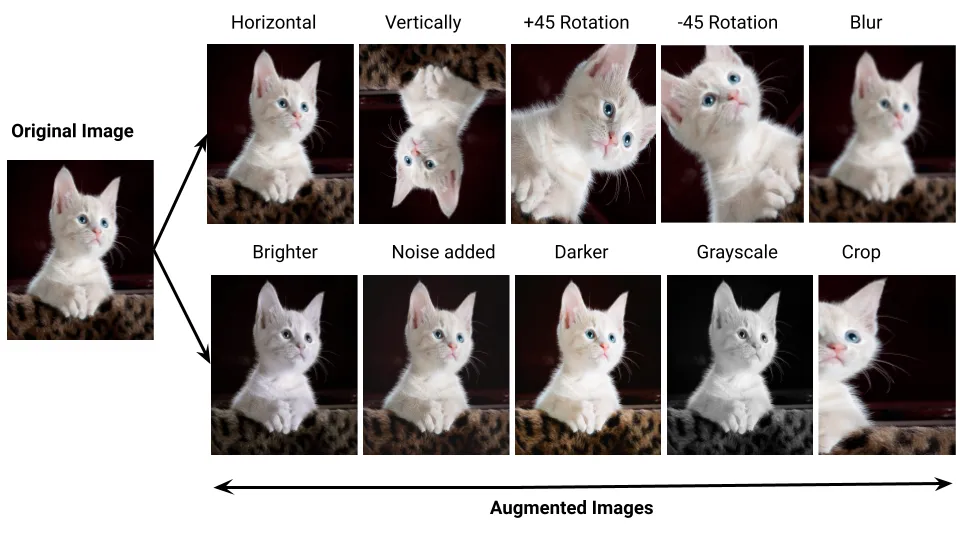

Nhìn qua tấm ảnh trên, chắc mọi người cũng có thể hiểu ngay được phương pháp này rồi ha. Nó sẽ thông qua việc **xoay, lật, đổi màu, phóng to, thu nhỏ cũng như cắt xén hình ảnh**, từ đó tạo ra được nhiều hình ảnh mới hơn từ một ảnh ban đầu của chúng ta.

Và chúng ta có thể thực hiện chúng ngay trong phương thức **ImageDataGenerator**.

In [ ]:
import urllib.request
import zipfile

# Link để download bộ dữ liệu huấn luyện horse-or-human
url = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"

file_name = "horse-or-human.zip"
training_dir = "horse-or-human/training/"
urllib.request.urlretrieve(url, file_name)

# Giải nén file zip
zip_ref = zipfile.ZipFile(file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40, # Xoay ngẫu nhiên từ 0 đến 40 độ qua trái hoặc phải
    width_shift_range = 0.2, # Dịch hình ảnh qua trái hoặc phải từ 0 đến 20%
    height_shift_range = 0.2, # Dịch hình ảnh lên xuống từ 0 đến 20%
    shear_range = 0.2, # Cắt nghiên hình ảnh từ 0 đến 20%
    zoom_range = 0.2, # Phóng to, thu nhỏ hình ảnh ngẫu nhiên từ 0 đến 20%
    horizontal_flip = True, # Lật ngang hình ảnh
    fill_mode = 'nearest' # Các pixel mới được tạo ra dựa trên cấc pixel gần nhất
)

Bây giờ ta định nghĩa lại tập huấn luyện và tập hiệu chỉnh nha.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


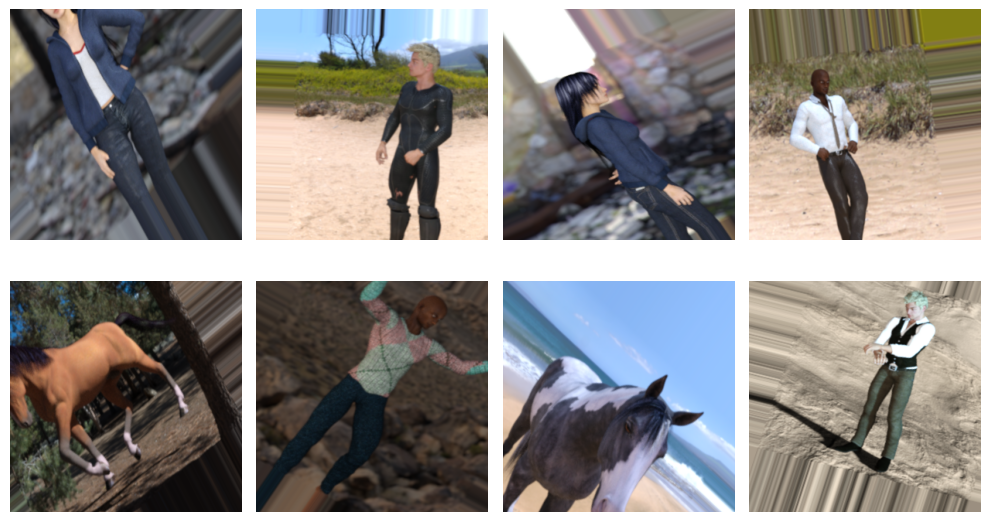

In [ ]:
# Xem 8 ảnh đầu tiên
fig, axs = plt.subplots(2, 4, figsize = (10, 6))
axs = axs.flatten()
for i in range(len(axs)):
  axs[i].imshow(train_generator[0][0][i])
  axs[i].axis('off')

plt.tight_layout()
plt.show()

Mọi người có thể thấy các hình ảnh đã bị cắt cũng như xoay, phóng to, thu nhỏ như chúng ta đã xác định trước đó, bây giờ chỉ cần huấn luyện và kiểm tra lại kết quả của mô hình thôi.

In [ ]:
# Tải bộ dữ liệu hiệu chỉnh (validation)
url = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"
validation_file_name = "validation-horse-or-human.zip"
validation_dir = 'horse-or-human/validation/'
urllib.request.urlretrieve(url, validation_file_name)

zip_ref = zipfile.ZipFile(validation_file_name, 'r')
zip_ref.extractall(validation_dir)
zip_ref.close()

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    class_mode='binary'
)

Found 256 images belonging to 2 classes.


In [ ]:
# Định nghĩa mô hình, mô hình này cũng giống mô hình trước đó à,
# mình viết lại nếu trong trường hợp các bạn muốn bắt đầu huấn luyện luôn từ bước này
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer = RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data = validation_generator
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 714ms/step - accuracy: 0.5432 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.9540
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 640ms/step - accuracy: 0.6724 - loss: 0.6223 - val_accuracy: 0.6797 - val_loss: 0.7598
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 646ms/step - accuracy: 0.7342 - loss: 0.5019 - val_accuracy: 0.5586 - val_loss: 0.9461
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 674ms/step - accuracy: 0.7739 - loss: 0.4749 - val_accuracy: 0.5781 - val_loss: 1.6304
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 622ms/step - accuracy: 0.8111 - loss: 0.3983 - val_accuracy: 0.5781 - val_loss: 1.4852
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 645ms/step - accuracy: 0.8737 - loss: 0.3147 - val_accuracy: 0.7070 - val_loss: 0.8168
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 656ms/step - accuracy: 0.8932 - loss: 0.2772 - val_accuracy: 0.7344 - val_loss: 1.1470
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 659ms/step - accuracy: 0.9014 - loss: 0.2926 - val_accuracy: 0.664

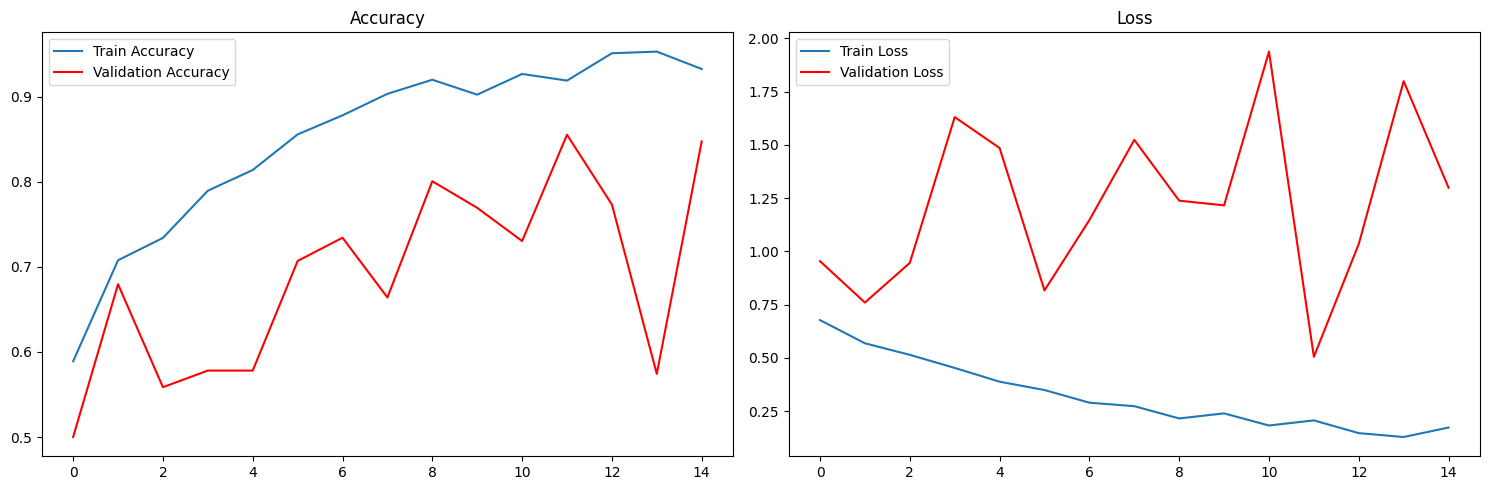

In [ ]:
# Vẽ biểu đồ đánh giá quá trình train trên 15 epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(acc, label='Train Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy', color = 'red')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[1].plot(loss, label='Train Loss')
axs[1].plot(val_loss, label='Validation Loss', color = 'red')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Kết quả đánh giá trên tập val
result = model.evaluate(validation_generator)
for i,m in enumerate(model.metrics_names):
  print(f"Kết quả đánh giá {m} trên tập val: {result[i]}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8608 - loss: 1.0985
Kết quả đánh giá loss trên tập val: 1.298774003982544
Kết quả đánh giá compile_metrics trên tập val: 0.84765625


Mọi người có thể thấy rõ trong lần chạy của mình, mô hình đã hiệu quả hơn nhiều trên tập hiệu chỉnh (tăng hơn 5%). Tuy là quá trình lúc đầu, tốc độ tăng trưởng của độ chính xác có phần chậm hơn, tuy nhiên có thể khái quát nhiều trường hợp hơn trên tập hiệu chỉnh.

Bây giờ mình sẽ tiến hành dự đoán lại các hình mình đã tải trước đó.

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

# Danh sách để lưu kết quả dự đoán
predicted_result = []

uploaded = files.upload()

for fn in uploaded.keys():
  # Lấy đường dẫn hình ảnh
  path = '/content/' + fn

  # Tiến hành lấy dữ liệu hình ảnh
  # Ảnh up lên có thể có nhiều kích thước khác nhau nên mình cần xác định lại về đúng kích thước đầu vào của mô hình (300 x 300).
  img = image.load_img(path, target_size = (300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  # Dự đoán hình ảnh
  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  pred_label = 0 if classes[0] < 0.5 else 1

  if pred_label == 1:
    print(f"Kết quả dự đoán {fn} là người.")
  else:
    print(f"Kết quả dự đoán {fn} là ngựa.")

  predicted_result.append([img, pred_label])


Saving OIP.jpeg to OIP (8).jpeg
Saving OIP (1).jpeg to OIP (1) (2).jpeg
Saving OIP (2).jpeg to OIP (2) (2).jpeg
Saving OIP (3).jpeg to OIP (3) (2).jpeg
Saving OIP (4).jpeg to OIP (4) (2).jpeg
Saving OIP (5).jpeg to OIP (5) (2).jpeg
Saving OIP (6).jpeg to OIP (6) (2).jpeg
Saving R.jpeg to R (2).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Kết quả dự đoán OIP (8).jpeg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Kết quả dự đoán OIP (1) (2).jpeg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Kết quả dự đoán OIP (2) (2).jpeg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Kết quả dự đoán OIP (3) (2).jpeg là ngựa.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Kết quả dự đoán OIP (4) (2).jpeg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Kết quả dự đoán OIP (5) (2).jpeg là ngựa.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Kết quả dự đoán OIP (6) (2).jpeg là ngựa.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Kết quả dự đoán R (2).jpeg là ngựa.


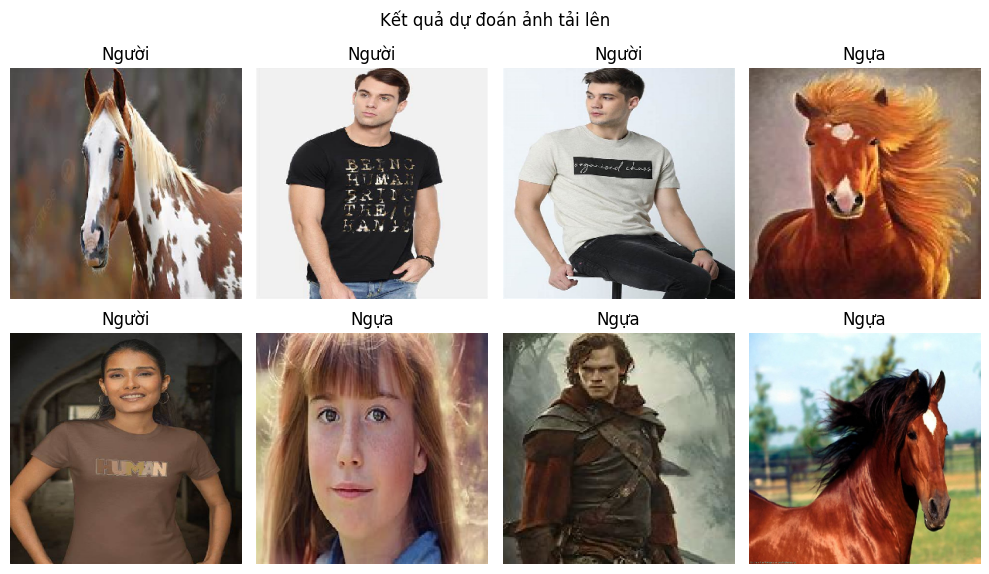

In [ ]:
# Trực quan hình ảnh và kết quả dự đoán
n_imgs = len(predicted_result)
n_cols = 4
# Tính số hàng một cách linh động
if n_imgs % n_cols == 0:
  n_rows = n_imgs // n_cols
else:
  n_rows = n_imgs // n_cols + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize = (10, 6))
axs = axs.flatten()
for i in range(n_imgs):
  axs[i].imshow(predicted_result[i][0])
  pred_label = "Người" if predicted_result[i][1] == 1 else "Ngựa"
  axs[i].set_title(pred_label)
  axs[i].axis('off')

fig.suptitle("Kết quả dự đoán ảnh tải lên")

plt.tight_layout()
plt.show()

Đây là kết quả ở lần chạy của mình.

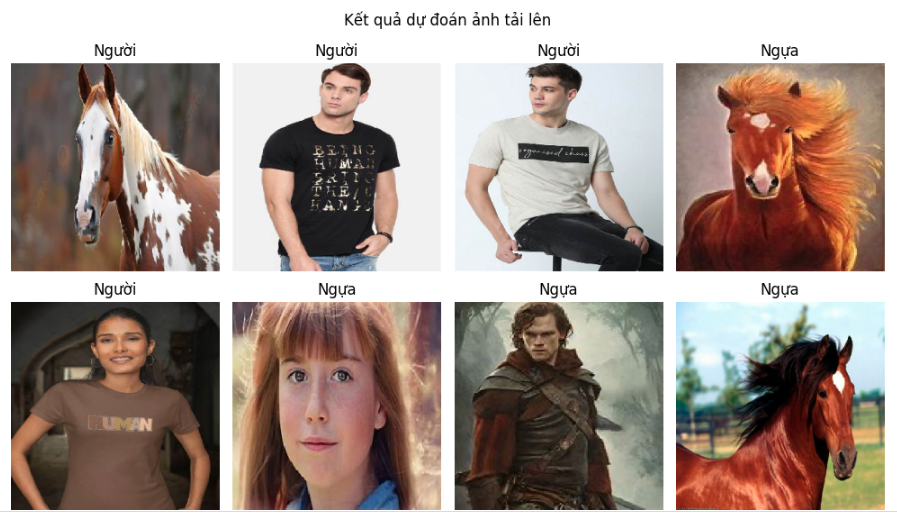

Có vẻ không hiệu quả hơn nhiều lắm, tuy nhiên đã có thể dự đoán đúng được rằng chị áo nâu là con người =)). Nói chung, phương pháp gia tăng ảnh này là như vậy á, nó sẽ giúp mô hình học được phần nào đó nhiều kiến thức đa dạng hơn.

Phiên mô hình lần này, mình chỉ sử dụng các hình ảnh đã được biến đổi để huấn luyện. Mọi người cũng có thể kết hợp với tập hình ảnh gốc ban đầu để có thêm nhiều dữ liệu hơn rồi huấn luyện, có thể kết quả sẽ còn cao hơn nữa.

## Tổng kết về phương pháp tăng cường hình ảnh (image augmentation)

Là phương pháp thông qua các phép biến đổi hình ảnh như **xoay, cắt, làm nhiễu, lật, phóng to, thu nhỏ,...** để tạo ra được nhiều hình ảnh đa dạng hơn, từ đó có thể gia tăng dữ liệu cho mô hình học tập.